In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

In [133]:
data = pd.read_csv("data_mot.csv", delimiter=";",header=0)

In [134]:
data.head()


,subj,trial,load,p_size
0,701,1,2,1021.408566
1,701,2,1,951.434880
2,701,3,5,1063.956947
3,701,4,4,913.487077
4,701,5,0,602.686850


In [135]:
mu = np.mean(data.p_size.values)
alpha = 100
beta = 100
sigma = np.std(data.p_size.values)

print("Mu: ", mu)
print("Sigma: ", sigma)

# x = np.linspace(0, 10, N)
# y = alpha + beta * x + np.random.normal(0, sigma, size=N)
# x = np.array(data["load"])
y = np.array(data.p_size.values)

Mu:  701.0583526909475
Sigma:  134.4058906295528


In [136]:
data_dict = {
    'y': data.p_size.values,
    # 'x': x,
    'N': len(data),
    # 'mu': mu,
    # 'sigma': sigma
}

In [137]:
program_code = """

data {
    int<lower=1> N;
    vector[N] y;
}

parameters {
    real mu;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    mu ~ normal(900, 1100);
    sigma2 ~ inv_gamma(1, 1);

    // Data model (likelihood)
    for (n in 1:N) {
        y[n] ~ normal(mu, sigma);
    }
} 

"""

In [138]:
model = stan.build(program_code, data = data_dict)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_ncr3m8t6/model_w27zwmnm.stan', line 20, column 21: Argument
    1100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ncr3m8t6/model_w27zwmnm.stan', line 20, column 16: Argument
    900 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [139]:
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


In [140]:
### Explore raw model outouts
results_df = fit.to_frame()

In [141]:
results_df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma2,sigma
draws,,,,,,,,,,
0,-232.296566,0.958152,0.772275,2.0,3.0,0.0,233.158007,670.924051,17630.224830,132.778857
1,-233.255326,0.842056,0.709445,2.0,3.0,0.0,233.473309,740.784907,16232.872860,127.408292
2,-231.319598,0.999735,0.762395,3.0,7.0,0.0,232.154713,708.018689,16340.725854,127.830849
3,-231.564966,0.948166,0.833329,3.0,7.0,0.0,232.285025,714.442663,15644.721020,125.078859
4,-232.194623,0.988176,0.772275,3.0,7.0,0.0,233.199123,714.150153,22983.829404,151.604187


In [142]:
results_df.shape

(4000, 10)

In [143]:
### Summarize model
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,700.771,21.248,660.367,740.424,0.411,0.291,2662.0,2291.0,1.0
sigma2,18633.403,4372.784,11775.799,27258.277,88.212,63.863,2568.0,2241.0,1.0
sigma,135.623,15.489,109.074,165.529,0.309,0.221,2568.0,2241.0,1.0


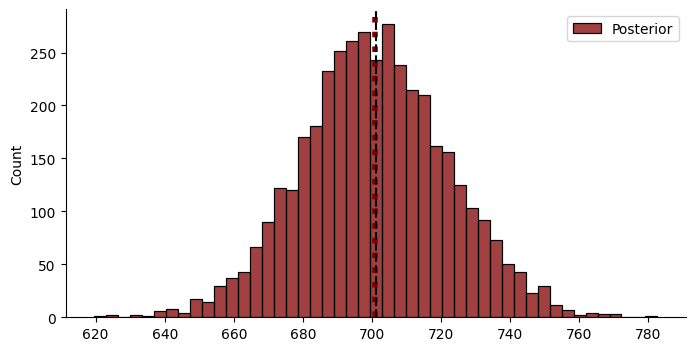

In [144]:
prior_samples = np.random.normal(0, 3, size=4000)
post_samples = results_df.mu.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
# sns.histplot(prior_samples, ax=ax, color="gray", alpha=0.8, label="Prior")
sns.histplot(post_samples, color='maroon', ax=ax, label="Posterior")
ax.axvline(np.mean(post_samples), color="maroon", linestyle="dotted", lw=4)
ax.axvline(mu, color="black", linestyle="dashed")
sns.despine(ax=ax)
ax.legend()

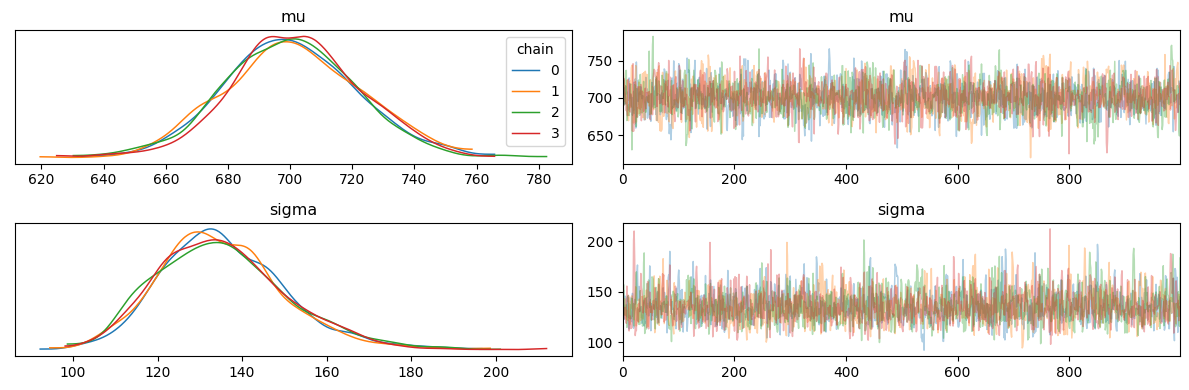

In [145]:
### Visual inspection and diagnostics
az.plot_trace(fit, var_names=['mu', 'sigma'], compact=False, legend=True)
plt.tight_layout()

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

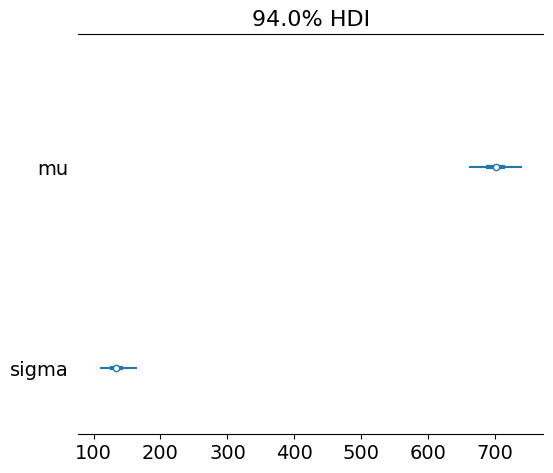

In [146]:
### Forest plots
az.plot_forest(fit, var_names=['mu', 'sigma'], combined=True)

Text(0, 0.5, '$\\sigma$')

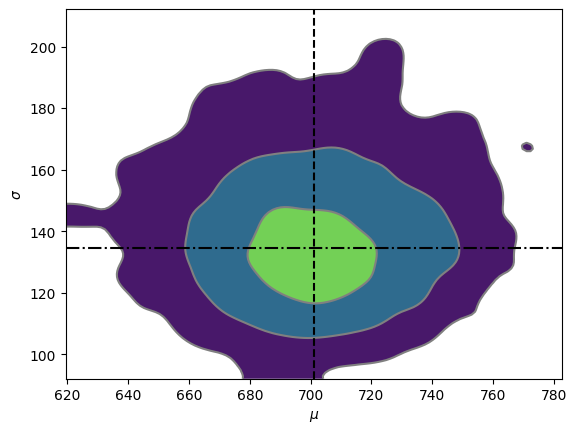

In [147]:
### Plot KDEs
ax = az.plot_kde(results_df.mu, 
                 results_df.sigma, hdi_probs=[0.393, 0.86, 0.99])
ax.axvline(mu, color='black', linestyle='--')
ax.axhline(sigma, color='black', linestyle='-.')
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\sigma$")

## Bayesian regression model

Next, we will build a simple Bayesian regression model of the form:
$$
\begin{align}
    \nonumber \sigma^2 &\sim \text{Inv-Gamma}(1, 1)\\
    \nonumber \alpha &\sim \mathcal{N}(0, 5)\\
    \nonumber \beta &\sim \mathcal{N}(0, 5)\\
\nonumber y_n &\sim \mathcal{N}(\alpha + \beta\,x_n, \sigma^2) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

In [148]:
mu = np.mean(data.p_size.values)
sigma = np.std(data.p_size.values)
alpha = np.random.normal(0, 5, size=data.p_size.values.shape)
beta = np.random.normal(0, 5, size=data.p_size.values.shape)

print("Mu: ", mu)
print("Sigma: ", sigma)

# x = np.linspace(0, 10, N)
# y = alpha + beta * x + np.random.normal(0, sigma, size=N)
# x = np.array(data["load"])
# y = np.array(data.p_size.values)

Mu:  701.0583526909475
Sigma:  134.4058906295528


In [149]:
data_dict = {
    'N': len(data),
    'y': data.p_size.values,
    'x': data.load.values,
    # 'mu': mu,
    # 'sigma': sigma
}

In [153]:
#### Your code here

program_code = """

data {
    int<lower=1> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    //No priors
    // Priors
    y ~ normal(alpha + beta*x, sigma);
} 

"""

In [154]:
### Buld model
model = stan.build(program_code, data = data_dict)

Building...



Building: 39.5s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [155]:
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


In [156]:
### Explore raw model outouts
results_df = fit.to_frame()

In [157]:
results_df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma2,sigma
draws,,,,,,,,,,,
0,-211.529003,0.959240,0.396676,3.0,15.0,0.0,212.987098,640.076323,42.677888,12431.742670,111.497725
1,-208.960283,0.986010,0.442662,3.0,7.0,0.0,209.313097,582.696454,41.990891,12158.434508,110.265291
2,-209.138427,0.971497,0.409197,2.0,3.0,0.0,209.303959,625.226644,41.982492,13529.212755,116.315144
3,-209.222212,0.713670,0.486305,2.0,3.0,0.0,211.750081,656.205608,32.530216,15436.884774,124.245261
4,-211.651718,0.987958,0.396676,2.0,3.0,0.0,212.161171,588.773840,27.737704,12390.833645,111.314121


In [158]:
results_df.shape

(4000, 11)

In [159]:
### Summarize model
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,617.576,35.314,551.726,683.625,0.832,0.588,1804.0,2207.0,1.0
beta,34.188,11.934,12.030,56.862,0.290,0.211,1718.0,2116.0,1.0
sigma2,17386.643,4265.966,10060.721,25116.985,93.548,66.157,2036.0,2054.0,1.0
sigma,130.909,15.795,103.268,161.036,0.347,0.246,2036.0,2054.0,1.0


In [ ]:
prior_samples = np.random.normal(0, 3, size=4000)
post_samples = results_df.mu.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
# sns.histplot(prior_samples, ax=ax, color="gray", alpha=0.8, label="Prior")
sns.histplot(post_samples, color='maroon', ax=ax, label="Posterior")
ax.axvline(np.mean(post_samples), color="maroon", linestyle="dotted", lw=4)
ax.axvline(mu, color="black", linestyle="dashed")
sns.despine(ax=ax)
ax.legend()

In [ ]:
### Visual inspection and diagnostics
az.plot_trace(fit, var_names=['mu', 'sigma'], compact=False, legend=True)
plt.tight_layout()

KeyError: 'var names: "[\'mu\'] are not present" in dataset'

In [ ]:
### Forest plots
az.plot_forest(fit, var_names=['mu', 'sigma'], combined=True)

In [ ]:
### Plot KDEs
ax = az.plot_kde(results_df.mu, 
                 results_df.sigma, hdi_probs=[0.393, 0.86, 0.99])
ax.axvline(mu, color='black', linestyle='--')
ax.axhline(sigma, color='black', linestyle='-.')
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\sigma$")